In [24]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

I_4=tinyarray.array(np.kron(sigma_0, sigma_0))
gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))   
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))  
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
las=1
width=30
c=1.0


In [25]:

def make_syst(width=50,length=100):
    
    #EG能
    EG_onsite    = (4*c)/las**2 * I_4
    EG_hopping_x = -c/(las**2)*I_4
    EG_hopping_y = -c/(las**2)*I_4 
    
    #TI能
    def onsite(site,m):
        return m/2*gamma_1 - (4*B)/las**2 * gamma_2
    hopping_x = B / (las ** 2) * gamma_2 + 1j * g / (2 * las) * gamma_3
    hopping_y = B / (las ** 2) * gamma_2 - 1j * g / (2 * las) * gamma_4


    #scattering能量模型
    def model():
        structure=kwant.lattice.square(las,norbs=4)
        model_sym= kwant.TranslationalSymmetry(structure.vec((-1,0)),structure.vec((0,-1)))
        model_1= kwant.Builder(model_sym)

        model_1[structure(0, 0)] = EG_onsite
        model_1[kwant.builder.HoppingKind((1,0), structure)]  =EG_hopping_x 
        model_1[kwant.builder.HoppingKind((0,1), structure)]  =EG_hopping_y

        return model_1
    
    #lead能量模型
    def model_lead():
        structure=kwant.lattice.square(las,norbs=4)
        model_sym= kwant.TranslationalSymmetry(structure.vec((-1,0)),structure.vec((0,-1)))
        model_1= kwant.Builder(model_sym)

        model_1[structure(0, 0)] = onsite
        model_1[kwant.builder.HoppingKind((1,0), structure)]  = hopping_x
        model_1[kwant.builder.HoppingKind((0,1), structure)]  = hopping_y

        return model_1

    ##create the scattering center

    def shape_center(site):
        x, y = site.pos
        return ((0 < x <= length) and (y==1 or y==width)) or ((x==1 or x==length) and (0 < y <= width))
    syst= kwant.Builder()
    syst.fill(model(), shape_center,(1,1))

    ##create the leads
    width_lead = length//5 

    lead0= kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    lead1= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead2= kwant.Builder(kwant.TranslationalSymmetry((0,1)))

    def shape_lead0(site):
        x, y = site.pos
        return 0 < y <= width

    def shape_lead1(site):
        x, y = site.pos
        return width_lead < x <= 2*width_lead

    def shape_lead2(site):
        x, y = site.pos
        return 3*width_lead < x <= 4*width_lead

    lead0.fill(model_lead(), shape_lead0, (0, 1))
    lead1.fill(model_lead(), shape_lead1, (width_lead+1, 0))
    lead2.fill(model_lead(), shape_lead2, (3*width_lead+1, 0))

    ########### create the six-terminal device
    for lead in [lead0,lead1,lead2, lead0.reversed(),lead2.reversed(),lead1.reversed()]:
        syst.attach_lead(lead)

    return syst.finalized()  

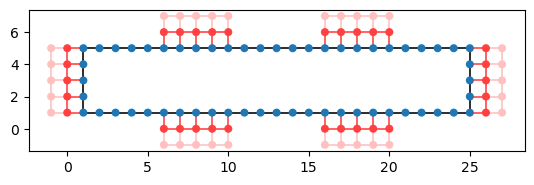

In [28]:
syst_1=make_syst(5,25)  
kwant.plot(syst_1) ;

计算电流分布

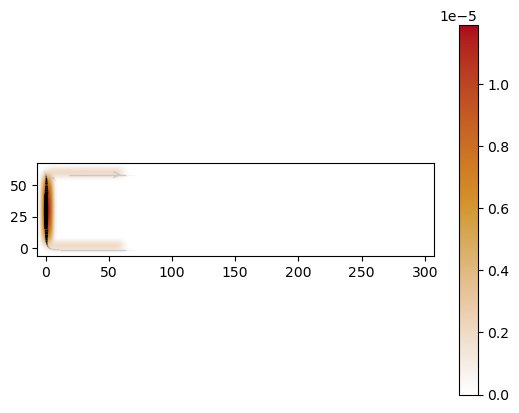

In [27]:
fsyst = make_syst(60,300)

J=kwant.operator.Current(fsyst)            #这个对象是一个电流算符，可以用来计算系统 fsyst 中任意两个相邻格点（跳跃，hopping）之间的局部电流密度。
wf=kwant.wave_function(fsyst, energy=5,params=dict(m=50))  #它是一个包含了已计算好的散射波函数集合的对象。
psi=wf(0)[0]
current = J(psi)
kwant.plotter.current(fsyst, current, colorbar=True, show=True)

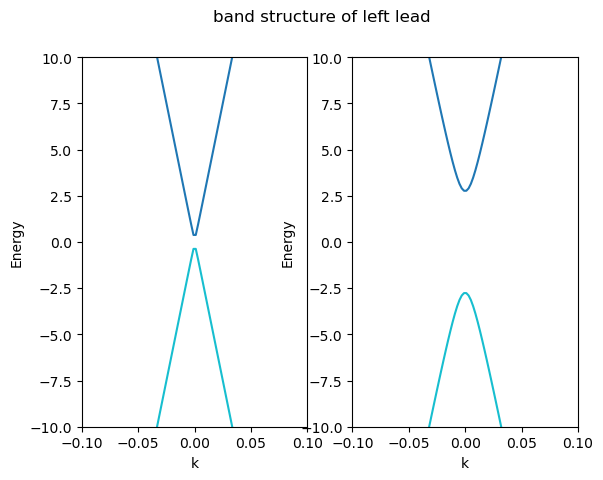

In [15]:
# 能带结构
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')
a_x=0.1
a_y=10
for ax in (ax1,ax2):
    ax.set_xlabel('k')
    ax.set_ylabel('Energy')
    ax.set_ylim(-a_y,a_y)
    ax.set_xlim(-a_x,a_x)

syst2=(make_syst(60,300)).leads[0] #提取系统的第一个引线
syst3=make_syst(60,300).leads[0]

kwant.plotter.bands(syst2,params=dict(m=50),momenta=np.linspace(-a_x, a_x, 100), ax=ax1);   #params 参数应该在调用 Kwant 的计算或绘图函数时传递，例如 kwant.plotter.bands()
kwant.plotter.bands(syst3,params=dict(m=20),momenta=np.linspace(-a_x, a_x, 100), ax=ax2);

In [30]:
syst1=make_syst(60,300).leads[0]
bands = kwant.physics.Bands(syst1, params=dict(m=20))
momenta=np.linspace(-0.05, 0.05, 200)

es=[]         # eigenvalues （200,240）
evs=[]        # eigenvectors （200,240,240）
for k in momenta:
    tem_a,tem_b= bands(k=k,return_eigenvectors = True) 
    es.append(tem_a)
    evs.append(tem_b)

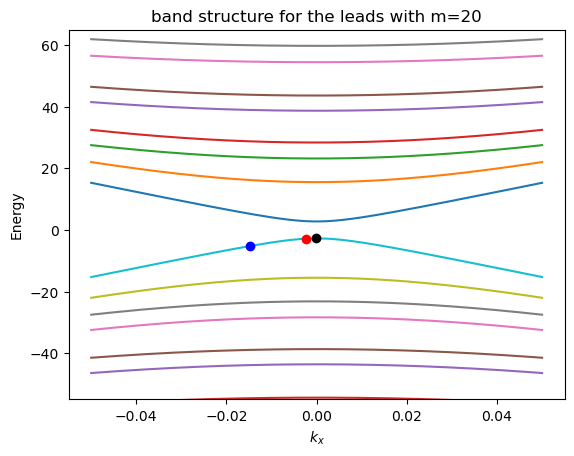

In [31]:
# the 100th, 96th and 70th states (k values) are chosen, the 120th energy level (band) is chosen
plt.plot(momenta,es);
plt.plot(momenta[99], es[99][119], 'ko')
plt.plot(momenta[95], es[95][119], 'ro')
plt.plot(momenta[70], es[70][119], 'bo')
plt.ylim(-55,65)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.title('band structure for the leads with m=20');

[(240,), (240,), (240,), (60, 4), (60,)]

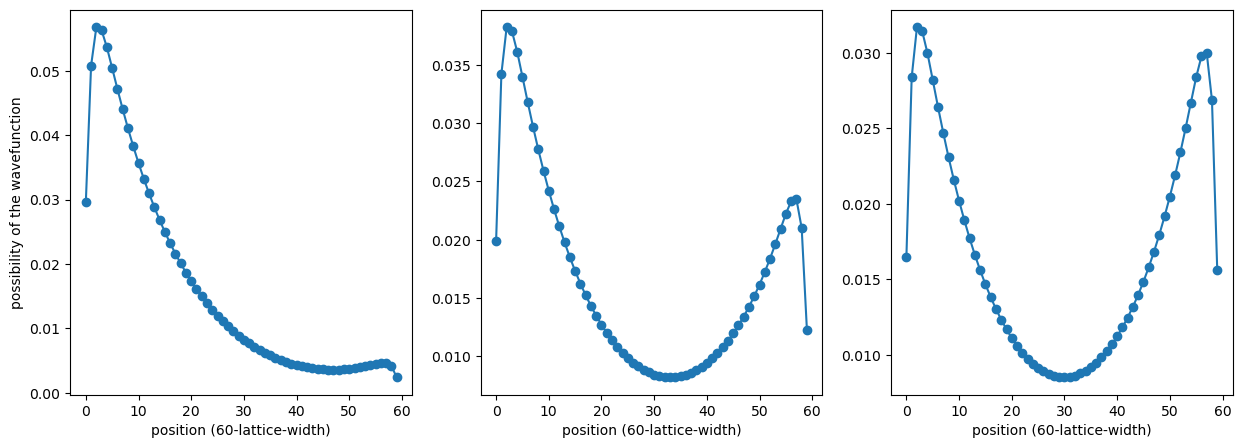

In [32]:
swf1=np.abs(evs[70][:,119])**2       #evs储存了200的k点的波函数（240✖️240）「第x列代表了第x能级的波函数，其波函数有240个分量」，evs[70]是第70个k点的波函数，evs[70][:,10]是第70个k点的第10个能级的波函数
swf2=np.abs(evs[95][:,119])**2       #[:,10] equals to the sumption of [0,10][1,10][2,10][3,10].... [240,10]
swf3=np.abs(evs[99][:,119])**2
fig,(ax1,ax2,ax3)=plt.subplots(1,3, figsize=(15,5))
ax1.plot(range(60),swf1.reshape((-1,4)).sum(1),'-o')
ax2.plot(range(60),swf2.reshape((-1,4)).sum(1),'-o')
ax3.plot(range(60),swf3.reshape((-1,4)).sum(1),'-o')

for ax in (ax1,ax2,ax3):
    ax.set_xlabel('position (60-lattice-width)')
ax1.set_ylabel('possibility of the wavefunction')

# 1. take the absolute value of the wavefunction and make the square
# 2. split the "array1" into parts (each parts has 4 values, i.e. the inner freedom of 4 at the same site is grouped) by using np.reshape(array1,(-1,4)), check the example-1 below
# 3. sum the parts splitted, i.e. sum the inner freedom of 4

swf2=np.abs(evs[70][:,119])
[np.array(swf2).shape,np.array(swf2**2).shape,np.array(swf2**3).shape,np.array(swf2).reshape((-1,4)).shape,np.array(swf2).reshape((-1,4)).sum(1).shape]
#SWF2 = np.array([11, 12, 33, 4, 5, 6, 7, 88])
#SWF2.reshape((-1, 4))             [[11, 12, 33,  4],[ 5,  6,  7, 88]]
#SWF2.reshape((-1, 4)).sum(1)      [60, 106]


In [33]:
def find_voltages(tmatrix,current):  #注意：该函数返回的V是所有V的矩阵        #tmatrix是传输矩阵，在此处还未定义，current是电流分布[1, 0, 0, -1, 0, 0] 表示电流从端口1流入，端口4流出。
    try:                                                            #np.linalg.solve()函数用于求解线性方程组，返回值是一个数组，数组中的每个元素是一个未知数的解   
        voltage = np.linalg.solve(tmatrix[1:, 1:], current[1:])     #tmatrix[1:, 1:]表示tmatrix的第一行和第一列被删去 current[1:]表示current的第一个元素被删去  
    except np.linalg.LinAlgError as err:                            #当检测到奇异矩阵时，即该函数无解，避免程序崩溃，强制返回零电压
        if 'Singular matrix' in str(err):
            print("Hi there, singular matrix here")
            voltage = [0,0,0,0,0]
        else:
            raise
    return [0, *voltage]    ##在电压列表前添加一个 0，表示第一个端口的电压为0（参考接地）。
  
def resistance_xx(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
  
    def resistance(a, b): 
        return voltage[a-1]-voltage[b-1] ##默认电流为1 ###将端口的序号索引转化为数组索引
  
    return resistance(2,3) ##电流从端口2流入，端口3流出，电压差为V2-V3
  
def resistance_xy(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
  
    def resistance(a, b):
        return voltage[a-1]-voltage[b-1]
  
    return resistance(2,6)  

def rMplot(m_list, data, ptitle='resistance vs m'):
    rxx=[]
    rxy=[]
    for i in range(data.shape[0]):
        rxx.append(resistance_xx(data[i]))
        rxy.append(resistance_xy(data[i]))

    plt.plot(m_list,rxx,'-o', label='$R_{xx}$')
    plt.plot(m_list,rxy,'-o', label='$R_{xy}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()


# define a function to plot the resistance vs energy
# here, "data" is a "np.array", a list (different energy) of 6*6 transimission matrices=[]
def rEplot(energies, data, ptitle='resistance vs energy'):
    rxx=[]
    rxy=[]
    for i in range(data.shape[0]):
        rxx.append(resistance_xx(data[i]))
        rxy.append(resistance_xy(data[i]))

    plt.plot(energies,rxx,'-o', label='$R_{xx}$')
    plt.plot(energies,rxy,'-o', label='$R_{xy}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('Energy')
    plt.ylabel('Resistance')
    plt.legend()

In [35]:
data=[]
syst=make_syst(60,300)
m_range=np.linspace(-50,50,num=50)
for m_value in m_range:
    tmatrix = kwant.smatrix(syst, 9.0,params=dict(m=m_value))
    data.append(tmatrix.conductance_matrix())

# cost around 2 mins

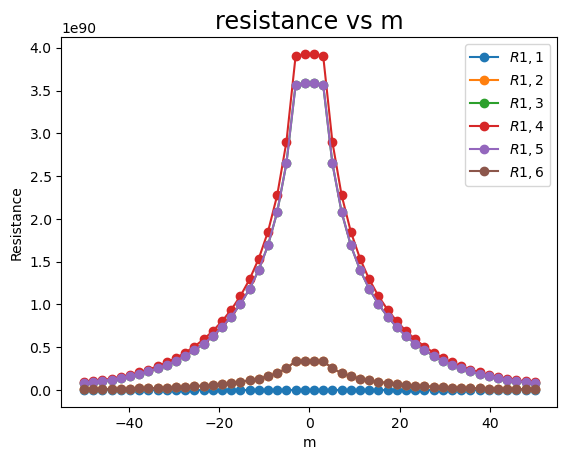

In [39]:
# One m, one resistance
r=[]
def rMplot_m(m_list, data, lead1=2,lead2=5, ptitle='resistance vs m'):
    current = [1, 0, 0, -1, 0, 0]
    rx=[]
    for i in range(data.shape[0]):
        voltage = find_voltages(data[i],current)
        rx.append(voltage[lead1-1]-voltage[lead2-1])
    r.append(rx[49])
    plt.plot(m_list,rx,'-o', label=f'$R {lead1},{lead2}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()
# double 3
rMplot_m(m_range,np.array(data),1,1)
rMplot_m(m_range,np.array(data),1,2)
rMplot_m(m_range,np.array(data),1,3)
rMplot_m(m_range,np.array(data),1,4)
rMplot_m(m_range,np.array(data),1,5)
rMplot_m(m_range,np.array(data),1,6)

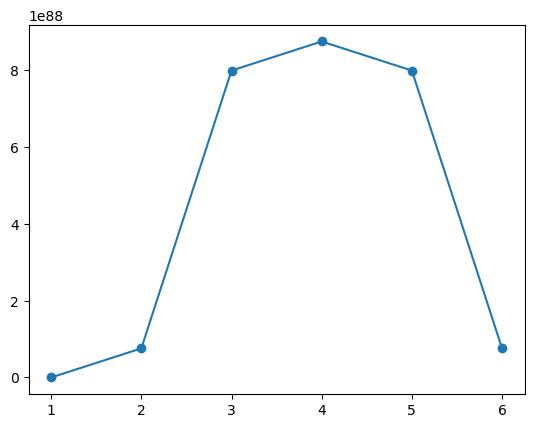

In [40]:
#voltage vs n
np.round(r,2)
num=[]
for i in range(7):
    num.append(i)
del num[0]
plt.plot(num,r,'-o', label='R')
plt.show()

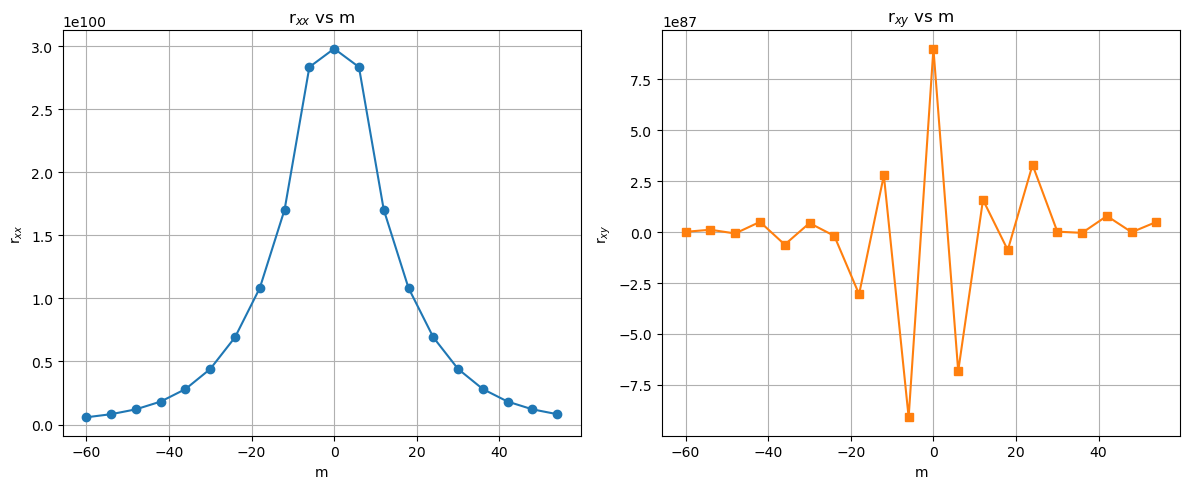

In [28]:
# 计算不同m值下的电阻
m_values = np.arange(-60, 60,6)  
rxx_list = []
rxy_list = []

for m in m_values:
    syst = make_syst(m, width=60, length=300)
    smat = kwant.smatrix(syst, energy=10.0)
    tmat = smat.conductance_matrix()            ######Transmission matrix
    rxx_list.append(resistance_xx(tmat))
    rxy_list.append(resistance_xy(tmat))

#画图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(m_values, rxx_list, 'o-', color='C0')
ax1.set_xlabel('m')
ax1.set_ylabel('r$_{xx}$')
ax1.set_title('r$_{xx}$ vs m')
ax1.grid(True)

ax2.plot(m_values, rxy_list, 's-', color='C1')
ax2.set_xlabel('m')
ax2.set_ylabel('r$_{xy}$')
ax2.set_title('r$_{xy}$ vs m')
ax2.grid(True)

plt.tight_layout()
plt.show()